In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt

In [2]:
current_directory = os.getcwd()
print(current_directory)
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

D:\boshi\GitHub\kears_learning\training_project\Natural Language Processing with Disaster Tweets


In [3]:
print(train.columns)
train.head(5)

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
train_label = train.target.to_numpy()

In [6]:
y_train = train_label.reshape(-1)

In [7]:
train.drop(['id', 'keyword', 'location', 'target'], axis=1, inplace=True)
test.drop(['id', 'keyword', 'location'], axis=1, inplace=True)

In [8]:
train = train.to_numpy()
test = test.to_numpy()
X_train = train.reshape(-1)
X_test = test.reshape(-1)

In [10]:
print(X_train[0])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all


In [11]:
all_tweets = np.append(X_train, X_test)

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

## Spilt train and valid data

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [13]:
import tensorflow as tf
raw_train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train))
raw_valid_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).shuffle(len(X_valid))
raw_test_ds = tf.data.Dataset.from_tensor_slices(X_test)

## Take a look at train dataset

In [14]:
for text_batch, label_batch in raw_train_ds.take(5):
    print('text=' + str(text_batch.numpy()))
    print('label=' + str(label_batch.numpy()))

text=b'320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vAM5POdGyw | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #Ices\xc2\x89\xc3\x9b_ http://t.co/zEVakJaPcz'
label=0
text=b"@Groupon_UK it won't let me as you don't follow me"
label=0
text=b"if firefighters acted like cops they'd drive around shooting a flamethrower at burning buildings"
label=0
text=b'Why must I have a meltdown every few days? ??'
label=0
text=b"'imagine an entire aisle dedicated to making people look like serbian refugees.' - director of whole foods clothing section"
label=0


## Normalization

In [15]:
import re
import string

def clean_tweet(tweet):

  #apostrophe
  tweet = re.sub(r'\x89Ûª', "'", tweet)
  tweet = re.sub(r'\x89Û÷', "'", tweet)

  #quotation
  tweet = re.sub(r'\x89ÛÏ', '"', tweet)
  tweet = re.sub(r'\x89Û\x9d', '"', tweet)

  #hyphen
  tweet = re.sub(r'\x89ÛÒ', '-', tweet)
  tweet = re.sub(r'\x89ÛÓ', '—', tweet)

  #euro
  tweet = re.sub(r'\x89âÂ', '€', tweet)

  #ellipsis
  tweet = re.sub(r'\x89Û_', '...', tweet)

  #amp
  tweet = re.sub(r'&', 'and', tweet)


  #bullet
  tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
  tweet = re.sub(r'\x89Û¢', '', tweet)


  #no idea
  tweet = re.sub(r'\x89ã¢', '', tweet)
  tweet = re.sub(r"å_", "", tweet)


  #other
  tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
  tweet = re.sub(r"åÊ", "", tweet)
  tweet = re.sub(r"åÈ", "", tweet)
  tweet = re.sub(r"JapÌ_n", "Japan", tweet)
  tweet = re.sub(r"Ì©", "e", tweet)
  tweet = re.sub(r"å¨", "", tweet)
  tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
  tweet = re.sub(r"åÇ", "", tweet)
  tweet = re.sub(r"å£3million", "3 million ", tweet)
  tweet = re.sub(r"åÀ", "", tweet)

  return tweet

def find_URL(text):
  url = re.compile(r'https?://\S+|www\.\S+')

  return url.findall(text)

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'This is a website.',text)

def remove_html(text):
  html=re.compile(r'<.*?>')
  return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)



In [54]:
def custom_standardization(input_data):
    r = clean_tweet(input_data)
    r = remove_URL(r)
    r = remove_html(r)
    r = remove_emoji(r)
    stripped_html = tf.strings.regex_replace(r, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )

In [17]:
# Model constants.
max_features = 20000
embedding_dim = 128
sequence_length = 500

In [55]:
from keras.layers import TextVectorization

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

## Let's make a text-only dataset (no labels):

In [52]:
all_tweets

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       ..., 'Green Line derailment in Chicago http://t.co/UtbXLcBIuY',
       'MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3',
       '#CityofCalgary has activated its Municipal Emergency Plan. #yycstorm'],
      dtype=object)

In [60]:
raw_tweets = raw_train_ds.map(lambda x, _: x)

vectorize_layer.adapt(raw_tweets)

TypeError: in user code:

    File "C:\Users\boshi\anaconda3\envs\boshi_intretech\lib\site-packages\keras\engine\base_preprocessing_layer.py", line 118, in adapt_step  *
        self.update_state(data)
    File "C:\Users\boshi\anaconda3\envs\boshi_intretech\lib\site-packages\keras\layers\preprocessing\text_vectorization.py", line 431, in update_state  **
        self._lookup_layer.update_state(self._preprocess(data))
    File "C:\Users\boshi\anaconda3\envs\boshi_intretech\lib\site-packages\keras\layers\preprocessing\text_vectorization.py", line 512, in _preprocess
        inputs = self._standardize(inputs)
    File "C:\Users\boshi\AppData\Local\Temp/ipykernel_12376/2244388441.py", line 2, in custom_standardization
        r = clean_tweet(input_data)
    File "C:\Users\boshi\AppData\Local\Temp/ipykernel_12376/1604632952.py", line 7, in clean_tweet
        tweet = re.sub(r'\x89Ûª', "'", tweet)
    File "C:\Users\boshi\anaconda3\envs\boshi_intretech\lib\re.py", line 210, in sub
        return _compile(pattern, flags).sub(repl, string, count)

    TypeError: expected string or bytes-like object


In [51]:
for text_batch in raw_tweets.take(5):
    print(text_batch)


tf.Tensor(b'No UK train accident fatalities for 8th year running despite 4% increase in passenger journeys http://t.co/SuiLzS2S95 @healthandsafety', shape=(), dtype=string)
tf.Tensor(b'@PrinceofFencing frickin summer and its humidity building up and causing trouble', shape=(), dtype=string)
tf.Tensor(b"@AvBronstein @Popehat @instapundit @KurtSchlichter Also are you aware of the casualty estimates for an invasion of Japan's home islands?", shape=(), dtype=string)
tf.Tensor(b'@LayLoveTournay @RyroTheUnaware [loud groaning] Let us bang.', shape=(), dtype=string)
tf.Tensor(b'Read an eyewitness account from #Hiroshima from this day in 1945 http://t.co/QUEDV2xxxX #LIFE', shape=(), dtype=string)


## Apply it to the text dataset

In [58]:
import tensorflow as tf
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [59]:
# Vectorize the data.
train_ds = raw_train_ds.map(vectorize_text)
# val_ds = raw_valid_ds.map(vectorize_text)
# test_ds = raw_test_ds.map(vectorize_text)
#
# # Do async prefetching / buffering of the data for best performance on GPU.
# train_ds = train_ds.cache().prefetch(buffer_size=10)
# val_ds = val_ds.cache().prefetch(buffer_size=10)
# test_ds = test_ds.cache().prefetch(buffer_size=10)

TypeError: in user code:

    File "C:\Users\boshi\AppData\Local\Temp/ipykernel_12376/2302180960.py", line 4, in vectorize_text  *
        return vectorize_layer(text), label
    File "C:\Users\boshi\anaconda3\envs\boshi_intretech\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\boshi\AppData\Local\Temp/ipykernel_12376/2244388441.py", line 2, in custom_standardization
        r = clean_tweet(input_data)
    File "C:\Users\boshi\AppData\Local\Temp/ipykernel_12376/1604632952.py", line 7, in clean_tweet
        tweet = re.sub(r'\x89Ûª', "'", tweet)
    File "C:\Users\boshi\anaconda3\envs\boshi_intretech\lib\re.py", line 210, in sub
        return _compile(pattern, flags).sub(repl, string, count)

    TypeError: Exception encountered when calling layer "text_vectorization_2" (type TextVectorization).
    
    expected string or bytes-like object
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(1,), dtype=string)


In [36]:
from keras.layers import *

def build_model():
    inputs = tf.keras.Input(shape=(None,), dtype="int64")

    # Next, we add a layer to map those vocab indices into a space of dimensionality
    # 'embedding_dim'.
    x = Embedding(max_features, embedding_dim)(inputs)
    x = Dropout(0.5)(x)

    # Conv1D + global max pooling
    x = Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
    x = Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
    x = GlobalMaxPooling1D()(x)

    # We add a vanilla hidden layer:
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)

    # We project onto a single unit output layer, and squash it with a sigmoid:
    predictions = Dense(1, activation="sigmoid", name="predictions")(x)

    model = tf.keras.Model(inputs, predictions)

    # Compile the model with binary crossentropy loss and an adam optimizer.
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [37]:
model_summary = build_model()
model_summary.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         2560000   
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 128)         114816    
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         114816    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                             

In [ ]:
lr = ReduceLROnPlateau(monitor="val_auc", mode='max', factor=0.7, patience=4, verbose=False)
es = EarlyStopping(monitor='val_auc',mode='max', patience=10, verbose=False,restore_best_weights=True)
model = build_model()
history = model.fit(X_train_part, y_train_part, validation_data=(X_valid, y_valid), epochs=epochs, batch_size=batch_size,
                    callbacks=[es,lr], verbose=verbose)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



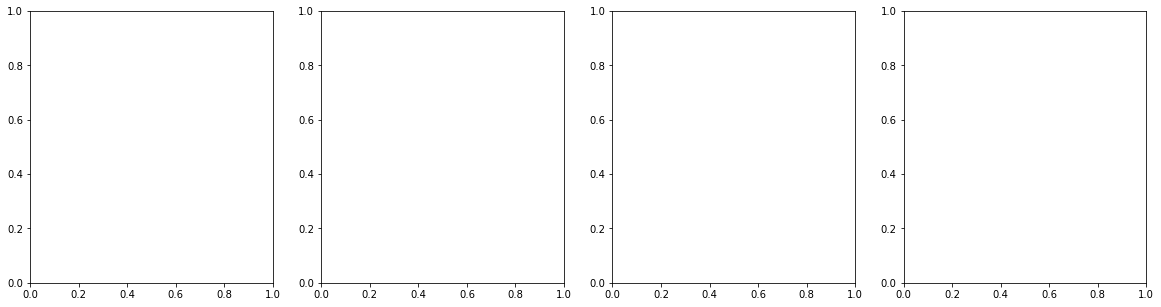

In [82]:
folds = 4
(test_preds, auc) = fit_model(folds, epochs=60, batch_size=64, verbose=True)

In [21]:
history = model_summary.fit(train_dataset.batch(256), epochs=50).history

Epoch 1/50
30/30 [==============================] - 9s 135ms/step - loss: 0.6126 - auc: 0.6972
Epoch 2/50
30/30 [==============================] - 4s 136ms/step - loss: 0.3636 - auc: 0.9082
Epoch 3/50
30/30 [==============================] - 4s 135ms/step - loss: 0.2130 - auc: 0.9677
Epoch 4/50
30/30 [==============================] - 4s 135ms/step - loss: 0.1259 - auc: 0.9881
Epoch 5/50
30/30 [==============================] - 4s 135ms/step - loss: 0.0896 - auc: 0.9936
Epoch 6/50
30/30 [==============================] - 4s 135ms/step - loss: 0.0705 - auc: 0.9961
Epoch 7/50
30/30 [==============================] - 4s 135ms/step - loss: 0.0661 - auc: 0.9963
Epoch 8/50
30/30 [==============================] - 4s 135ms/step - loss: 0.0648 - auc: 0.9952
Epoch 9/50
30/30 [==============================] - 4s 136ms/step - loss: 0.0620 - auc: 0.9966
Epoch 10/50
30/30 [==============================] - 4s 135ms/step - loss: 0.0498 - auc: 0.9983
Epoch 11/50
30/30 [==============================

KeyboardInterrupt: 

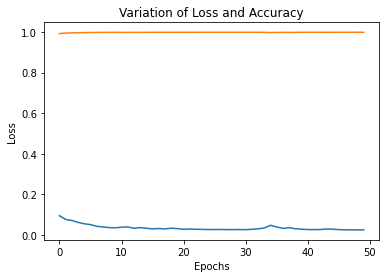

In [80]:
plt.figure()
plt.title('Variation of Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history['loss'])
plt.plot(history['auc'])